### This is the TRIANGLE-BASED C1 INTERPOLATION METHOD 
ref: https://projecteuclid.org/download/pdf_1/euclid.rmjm/1250127673

We start from an extremely sparce case: 100 observed pts / (700 * 700) pixels

In [1]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from scipy.ndimage.filters import gaussian_filter
from numpy.polynomial.chebyshev import chebfit, chebval2d, chebvander2d
from numpy.polynomial.polynomial import polyvander2d, polyval2d

import astropy.units as units
from astropy.coordinates import SkyCoord


from astropy.io import fits
with open("xye_1m.pickle","rb") as f:
    example_1 = pickle.load(f)

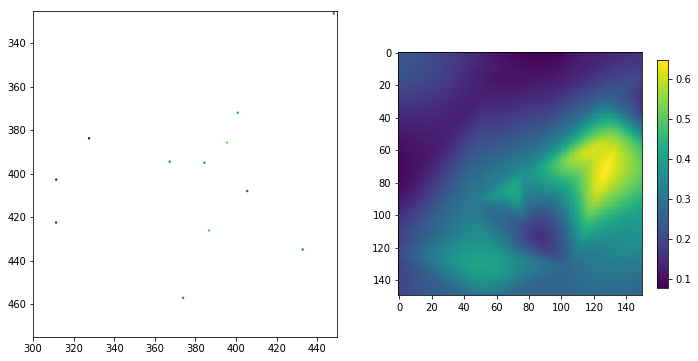

In [3]:
from scipy.interpolate import griddata
grid_y, grid_x = np.mgrid[300:450, 325:475]
grid=griddata(example_1[:100,:2],example_1[:100,2],(grid_x, grid_y),method='cubic')
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(example_1[:100,0],example_1[:100,1],c=example_1[:100, 2], s=2)
plt.ylim(475,325)
plt.xlim(300,450)
plt.subplot(122)
plt.imshow(grid)
plt.colorbar(shrink=0.7)

Generally not broke! We would expect any of our method to break in such settings.

### Next we are gonna test it: (without noise)

In [5]:
def FOM(reconstructed, target, margin=0):
    if margin:
        reconstructed = reconstructed[margin: -margin, margin: -margin]
        target = target[margin: -margin, margin: -margin]
        
    reconstructed = reconstructed.flatten()
    target = target.flatten()
    return np.sqrt(np.mean(np.square(reconstructed-target)))

def bicubic_and_compare(data,x_start=325,y_start=300 ,width=30,size=5):
    """
    (x_start,y_start) is the upper-left pixel index. when width>1, the first pixel drifts to 
        (x_start+(size-1)/2,y_start+(size-1)/2)
    (x_start+(width-1)*size+(size-1)/2 , y_start+(width-1)*size+(size-1)/2) is the 
        lower-right pixel index
    """
    x_end1=int(x_start+(width-1)*size+(size-1)/2)
    y_end1=int(y_start+(width-1)*size+(size-1)/2)
    x_start1=int(x_start+(size-1)/2)
    y_start1=int(y_start+(size-1)/2)
    
    grid_y, grid_x = np.mgrid[x_start1:x_end1:width*1j, y_start1:y_end1:width*1j]
    # must revert the sequence of x and y 
    #       meshgrid returns a reverted tuple 
    
    plt.figure(figsize=(18,6))
    grid=griddata(data[:,:2],data[:,2],(grid_x, grid_y),method='cubic')
    plt.subplot(131)
    plt.imshow(grid)
    plt.colorbar(shrink=0.7)
    plt.title('bicubic')
    
    #make_benchmark
    small = A[x_start1:x_end1+1:size, y_start1: y_end1+1 :size]

    plt.subplot(132)
    plt.imshow(small)
    plt.colorbar(shrink=0.7)
    plt.title('original')

    print ("FOM: {}".format(FOM(grid, small, margin=0)))
    
    plt.subplot(133)
    plt.scatter(data[:,0],data[:,1],c=data[:,2], s=2)
    plt.ylim(475,325)
    plt.xlim(x_start,450)
    print(x_start,x_start1,y_start,y_start1,x_end1,y_end1)

#### test1: 0.1 pts/pix

FOM: 0.056446413790689924
325 327 300 302 472 447


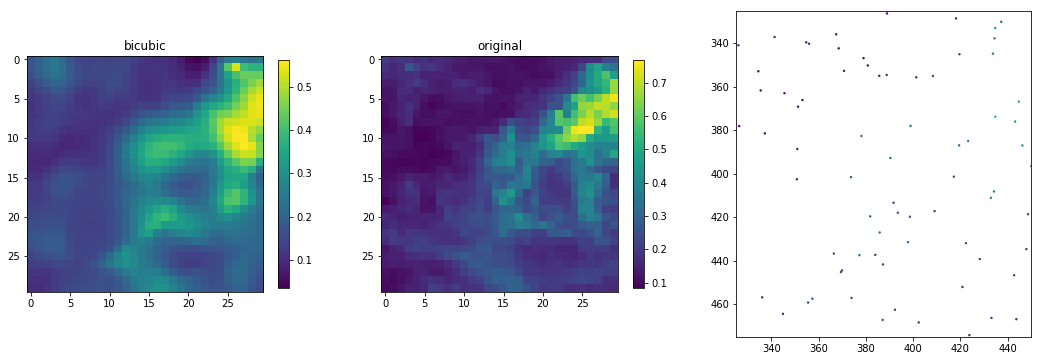

In [8]:
A = fits.getdata('full_700x700.fits')


bicubic_and_compare(example_1[::1000])

#### test2: 3 pts/pix

FOM: 0.006534594772117846
325 327 300 302 472 447


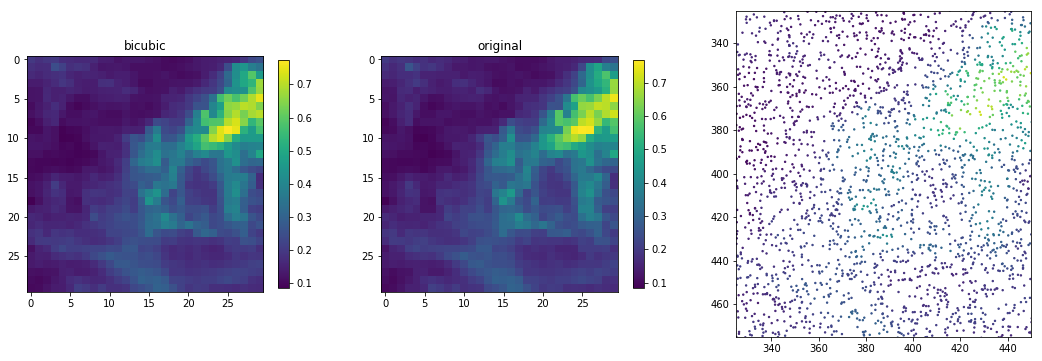

In [9]:
bicubic_and_compare(example_1[::33])

#### test3: 6 pts/pix

FOM: 0.003571653411736615
325 327 300 302 472 447


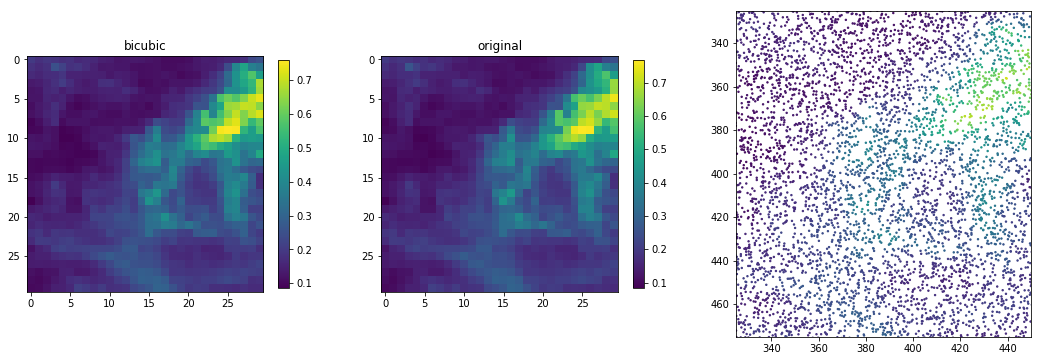

In [10]:
bicubic_and_compare(example_1[::15])

#### test4: 20 pts/pix

FOM: 0.0012585627731225956
325 327 300 302 472 447


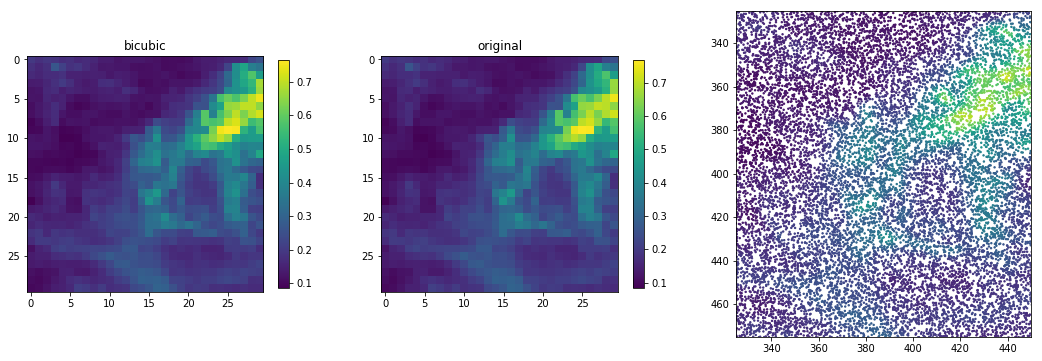

In [11]:
bicubic_and_compare(example_1[::5])

#### test5: 50 pts/pix

FOM: 0.0006980476201682639
325 327 300 302 472 447


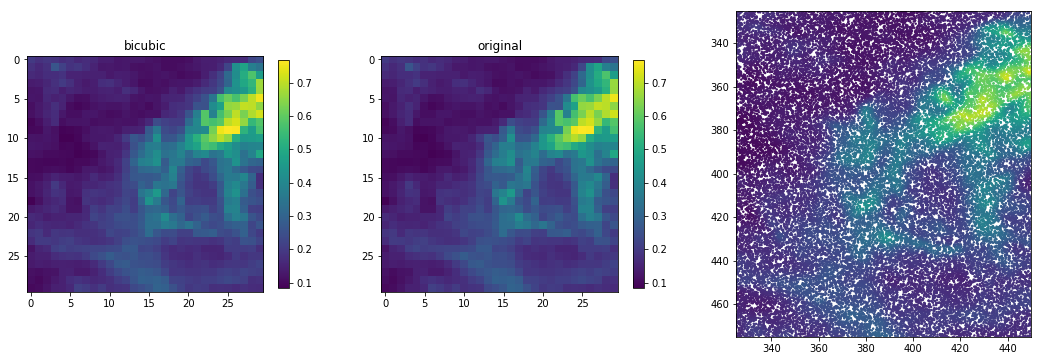

In [12]:
bicubic_and_compare(example_1[::2])

Compared with our previous result we see significant improvement using this algorithm, both in robustness and accuracy.

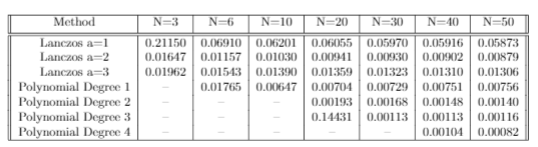

----------------------------